In [2]:
import xarray as xr
import numpy as np
import metpy as mp
import matplotlib.pyplot as plt


In [1]:
dataset = xr.open_dataset("CAM_FV3L30_HS_month_12.nc")
PS = dataset['PS'].values/100 #surface pressure (in hPa)
U850 = dataset['U850'].values #zonal wind (in m/s) at 850 hPa
V850 = dataset['V850'].values #meridional wind (in m/s) at 850hPa
T850 = dataset['T850'].values #temperature (in K) at 850 hPa
a = 6173*10**3 # radius of Earth in meters
Δλ = np.pi/90 #grid spacing in radians
Δϕ = np.pi/90
λ = np.linspace(1,359,PS.shape[2])
ϕ = np.linspace(-89,89,PS.shape[1])
lon,lat = np.meshgrid(λ,ϕ)

NameError: name 'xr' is not defined

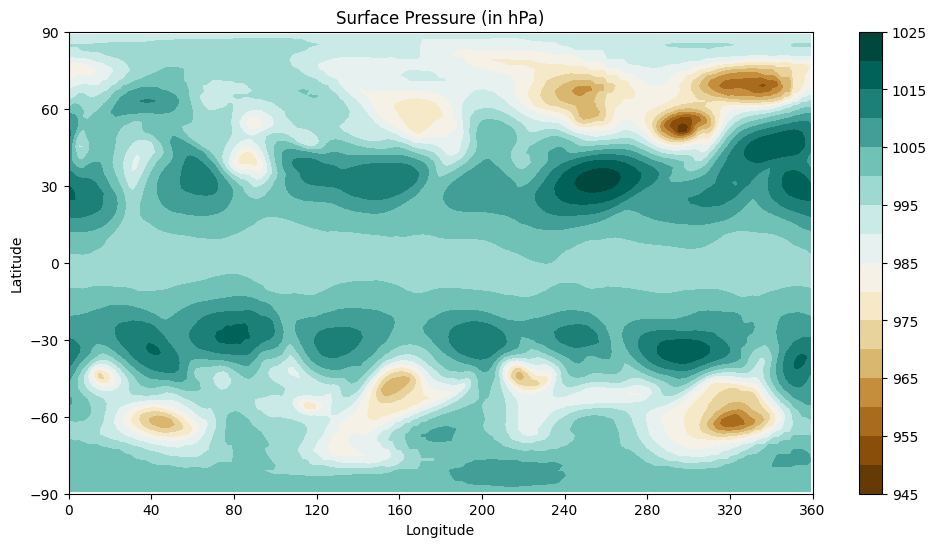

In [46]:
#Plot a contour plot of the surface pressure (in hPa) with a contour interval of 5 hPa
fig,ax = plt.subplots(1,1)
fig.set_size_inches(12,6) #2:1 aspect ratio
max_level = np.ceil(np.max(PS[0,:,:]))
min_level = np.floor(np.min(PS[0,:,:]))
step_level = 5

CF = ax.contourf(lon,lat,PS[0,:,:],levels = np.arange(min_level, max_level + step_level, step_level),cmap='BrBG')
cbar = fig.colorbar(CF)
ax.set_xticks(np.linspace(0,360,10))
ax.set_yticks(np.linspace(-90,90,7))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Surface Pressure (in hPa)")
# fig.savefig("surfacePressure_hPa.png",dpi=300)
plt.show()

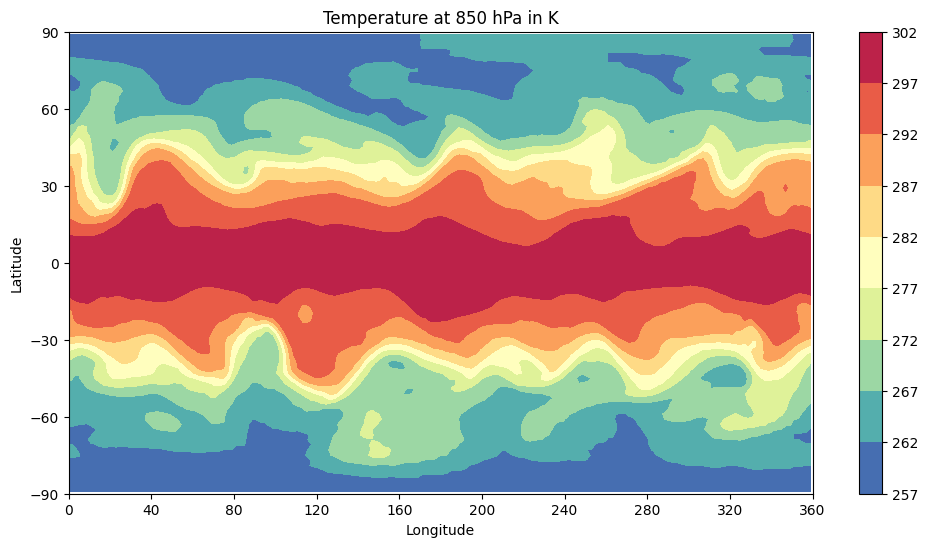

In [47]:
#Plot a contour plot of the T850 field with a contour interval of 5 K
fig,ax = plt.subplots(1,1)
fig.set_size_inches(12,6) #2:1 aspect ratio
max_level = np.ceil(np.max(T850[0,:,:]))
min_level = np.floor(np.min(T850[0,:,:]))
step_level = 5

CF = ax.contourf(lon,lat,T850[0,:,:],levels = np.arange(min_level, max_level + step_level, step_level),cmap=plt.cm.Spectral_r)
cbar = fig.colorbar(CF)
ax.set_xticks(np.linspace(0,360,10))
ax.set_yticks(np.linspace(-90,90,7))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Temperature at 850 hPa in K")
# fig.savefig("T850_K.png",dpi=300)
plt.show()

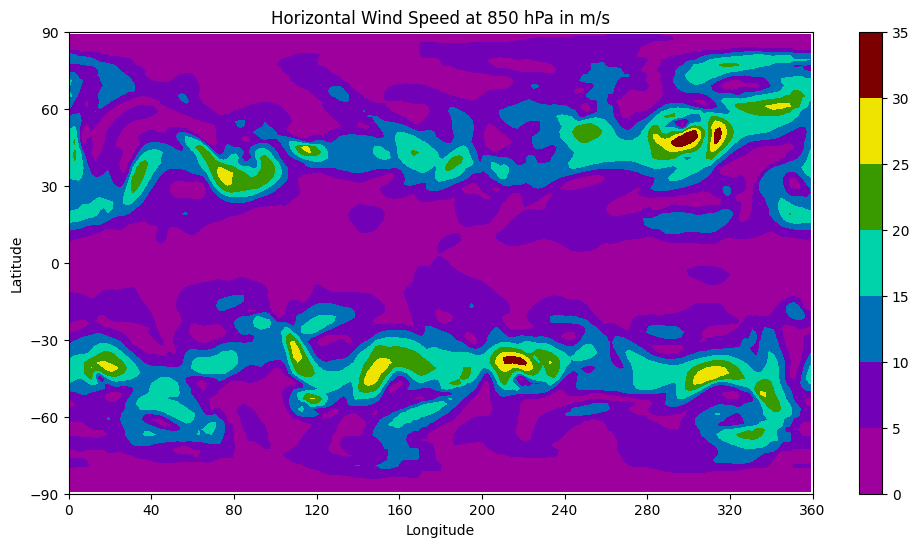

In [48]:
#Plot the horizontal wind speed at 850 hPa. Make your own decision about a suitable contour interval.
u850 = np.sqrt(U850**2+V850**2) #horizontal wind speed at 850 hPa

fig,ax = plt.subplots(1,1)
fig.set_size_inches(12,6) #2:1 aspect ratio

#set nice contour intervals
max_level = np.ceil(np.max(u850[0,:,:]))
min_level = np.floor(np.min(u850[0,:,:]))
step_level = 5

CF = ax.contourf(lon,lat,u850[0,:,:],levels = np.arange(min_level, max_level + step_level, step_level),cmap=mp.plots.colortables.get_colortable("ir_rgbv"))
cbar = fig.colorbar(CF)
ax.set_xticks(np.linspace(0,360,10))
ax.set_yticks(np.linspace(-90,90,7))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Horizontal Wind Speed at 850 hPa in m/s")
# fig.savefig("horzWindSpeed_m_s.png",dpi=300)
plt.show()

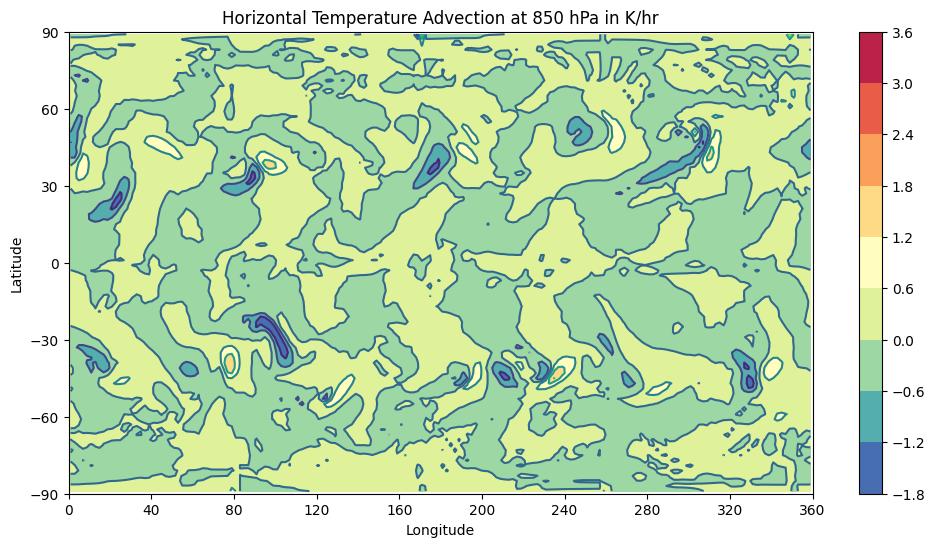

In [52]:
#Plot the horizontal temperature advection at 850 hPa. Make your own decision about a
#suitable contour interval. When using centered finite-difference it is okay to leave out the
#edge points (lon=1 and 359 and lat=-89 and 89) in your computation. Your plotted
#domain will then be a little smaller.

fig,ax = plt.subplots(1,1)
fig.set_size_inches(12,6) #2:1 aspect ratio

#calculating advection with a loop
adv_loop = np.zeros_like(T850[0,:,:])

for j in range(0,90):
    for i in range(0,180):
        if i==179:
            dTdλ = (1/(2*Δλ))*(T850[0,j,0]-T850[0,j,i-1])
        else:
            dTdλ = (1/(2*Δλ))*(T850[0,j,i+1]-T850[0,j,i-1])

        if j == 89:
            dTdϕ = (1/(2*Δϕ))*(T850[0,0,i]-T850[0,j-1,i]) #can't do this because the domain doesn't wrap
        else:
            dTdϕ = (1/(2*Δϕ))*(T850[0,j+1,i]-T850[0,j-1,i])

        adv_loop[j,i] = -U850[0,j,i] * (1/(np.cos(ϕ[j]*np.pi/180)*a))*dTdλ -V850[0,j,i] * (1/a)*dTdϕ



#calculate with np.gradient (both return similar answers)
dTdλ_dϕ=np.gradient(T850[0,:,:],Δλ,edge_order=2)
adv = -U850[0,:,:]*((1/(np.cos(ϕ*np.pi/180)*a))[:, np.newaxis]*dTdλ_dϕ[1])-V850[0,:,:]*((1/a)*dTdλ_dϕ[0]) #Advection in K/s

CF = ax.contourf(lon,lat,adv*3600,8,cmap=plt.cm.Spectral_r)
ax.contour(lon,lat,adv*3600,8)

cbar = fig.colorbar(CF)

ax.set_xticks(np.linspace(0,360,10))
ax.set_yticks(np.linspace(-90,90,7))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_title("Horizontal Temperature Advection at 850 hPa in K/hr")
# fig.savefig("T850Advection_K_hr.png",dpi=300)
plt.show()


In [7]:
#Compute the area-weighted mean temperature at 850 hPa.
T850_avg = 0
for i in range(0,len(ϕ)):
    for j in range(0,len(λ)):
        T850_avg += np.pi/(2*len(λ)*len(ϕ))*T850[0,i,j]*np.cos(lat[i,j]*np.pi/180) #my version


print(f"Area Temperature Average (loop): {T850_avg:.2f} K")



#standard weighted average calculation
weights = (np.cos(lat*np.pi/180))#if I use just the ϕ array it won't find the right total area because it doesn't reflect the whole double integral
weighted_sum = (weights * T850[0,:,:]).sum()
total_weight = weights.sum() # the total weight should be approximately nlon*(2/np.pi)*nlat
area_weighted_average = weighted_sum / total_weight

print(f"Area Temperature Average (weights): {area_weighted_average:.2f} K") 
# I think this differs from the loop because it numerically approximates the total area while I use an explicit analyical expression for the total area in the loop.



Area Temperature Average (loop): 283.86 K
Area Temperature Average (weights): 283.84 K
